In [2]:
!pip install gensim

    100% |████████████████████████████████| 23.7MB 2.0MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 4.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 27.8MB/s ta 0:00:01
    100% |████████████████████████████████| 6.2MB 4.7MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 18.3MB/s ta 0:00:01
  Stored in directory: /Users/mikeqin/Library/Caches/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built smart-open


In [68]:
import psycopg2
import pandas as pd
import numpy as np
import nltk
import re
from collections import Counter
import spacy
import gensim 
import warnings
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
warnings.simplefilter("ignore")

# I. Load Data

In [4]:
conn = psycopg2.connect(database="threadtogether", user="dso_student", password="-H4jgA`rn6w`=Jg(", host="threadtogether.ychennay.com", port="5432")

In [5]:
# View all the tables
cur = conn.cursor()
cur.execute("""select *  
                            from information_schema.tables
                            where table_schema='public'""")
data = cur.fetchall()

In [6]:
pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,threadtogether,public,full_data,BASE TABLE,None,None,None,None,None,YES,NO,None
1,threadtogether,public,womens_clothing_reviews,BASE TABLE,None,None,None,None,None,YES,NO,None
2,threadtogether,public,tagged_product_attributes,BASE TABLE,None,None,None,None,None,YES,NO,None
3,threadtogether,public,categories,BASE TABLE,None,None,None,None,None,YES,NO,None
4,threadtogether,public,outfits,BASE TABLE,None,None,None,None,None,YES,NO,None


In [7]:
# Extract data from full_data
cur = conn.cursor()
cur.execute("select *  from full_data")
data = cur.fetchall()

In [8]:
full_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [9]:
full_data.head()

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,514683,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,2019-11-11 22:37:15.719107+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,"A modern pump, in a rounded silhouette with an...","{""Needs Review""}",NULL
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,526676,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,2019-11-11 22:36:50.682513+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,Dress it down with jeans and sneakers or dress...,"{""Needs Review""}",NULL
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,4.001E+11,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,2019-11-13 17:33:59.581661+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/loewe-52mm-pad...,100% UV protection\nCase and cleaning cloth in...,"{""Needs Review""}",NULL
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,4.00012E+11,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",2019-11-13 17:05:05.203733+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/converse-babys...,Canvas upper\nRound toe\nLace-up vamp\nSmartFO...,"{""Needs Review""}",NULL
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,4.00011E+11,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,2019-11-13 18:42:30.941321+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/alexander-mcqu...,100% UV protection\nGradient lenses\nAdjustabl...,"{""Needs Review""}",NULL


In [10]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 13 columns):
product_id             48979 non-null object
brand                  48979 non-null object
mpn                    48979 non-null object
product_full_name      48979 non-null object
description            41005 non-null object
brand_category         48741 non-null object
created_at             48979 non-null object
updated_at             48979 non-null object
deleted_at             45984 non-null object
brand_canonical_url    48967 non-null object
details                47950 non-null object
labels                 48979 non-null object
bc_product_id          48979 non-null object
dtypes: object(13)
memory usage: 4.9+ MB


In [11]:
# Extract data from tagged_product_attributes
cur = conn.cursor()
cur.execute("select *  from tagged_product_attributes")
data = cur.fetchall()

In [12]:
tagged_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [50]:
tagged_data.head()

,product_id,product_color_id,attribute_name,attribute_value,file
0,01DVBTBPHR8WJTCVEN5AJRHF47,01DVBTBPJ41VVT00JJCG8TTZ2W,gender,Women,initial_tags
1,01DVA7QRXM928ZM0WWR7HFNTC1,01DVA7QRXXR9F0TWVE1HMC5ZQ3,Primary Color,Blacks,initial_tags
2,01DPGV4YRP3Z8J85DASGZ1Y99W,01DPGVGBK6YGNYGNF2S6FSH02T,style,Casual,initial_tags
3,01E1JM43NQ3H17PB22EV3074NX,01E1JM5WFWWCCCH3JTTTCYQCEQ,style,Modern,initial_tags
4,01DSE8Z2ZDAZKZ2SKCS1E3B3HK,01DSE8ZG8Y3FR8KWE2TY1QDWBF,shoe_width,Medium,initial_tags


In [48]:
tagged_data[tagged_data['attribute_value'] != ]

NameError: name 'NA' is not defined

In [14]:
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119345 entries, 0 to 119344
Data columns (total 5 columns):
product_id          119345 non-null object
product_color_id    119345 non-null object
attribute_name      119345 non-null object
attribute_value     119345 non-null object
file                119345 non-null object
dtypes: object(5)
memory usage: 4.6+ MB


In [15]:
# Extract data from womens_clothing_reviews
cur = conn.cursor()
cur.execute("select *  from womens_clothing_reviews")
data = cur.fetchall()

In [16]:
reviews = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [17]:
reviews.head()

,clothing_id,age,title,review_text,rating,recommend,likes,division,department,class
0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
clothing_id    23486 non-null int64
age            23486 non-null int64
title          19676 non-null object
review_text    22641 non-null object
rating         23486 non-null int64
recommend      23486 non-null int64
likes          23486 non-null int64
division       23472 non-null object
department     23472 non-null object
class          23472 non-null object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [19]:
# Extract data from categories
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()

In [42]:
# View
category = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
category[category["category"] == "category"]

,value,category,type,quantifier
64,Top,category,general,one
65,Bottom,category,general,one
66,One Piece,category,general,one
67,Shoe,category,general,one
68,Handbag,category,general,one
69,Scarf,category,general,one


For Category: <br/>
We consider following columns to identify occasions: product_full_name, description, brand_category, details.<br/>
There are six categories under categories:
* Top
* Bottom
* One Piece
* Shoe
* Handbag
* Scarf

# II. Text Preprocessing

In [21]:
# join full_data and tagged_data. Replace NAs and \n
join_data = full_data.merge(tagged_data, on='product_id')
join_data = join_data.replace(np.nan, "", regex=True)
join_data = join_data.replace("\n", "",regex=True)
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [22]:
# Lower case some target texts
columns_list = ['brand','product_full_name','description','brand_category','details',
                'attribute_name','attribute_value']
for column in columns_list:
    join_data[column] = join_data[column].str.lower()
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [23]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize

columns_list2 = ['brand','product_full_name','description','brand_category','details']
nltk_stopwords = set(stopwords.words('english') + [".",",",":","''","'s","'","``","(", ")","]",
                                                   "-","!","/",">","<",";","#","...","..","?","--","[","&"])
for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in nltk_stopwords]))
    
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [24]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# III. Modelling

In [26]:
# Michael's way of finding input texts you need (for reference) 
join_data['tag_info'] = join_data[['brand','product_full_name','description','brand_category','details']].apply(lambda x: ' '.join(x), axis=1)
join_data['tag_info'][0]

'a.l.c lennox high waist cotton linen pant high-rise trouser tailored cool italian cotton-and-linen blend make refreshing addition work wardrobe unknown true size high rise.31 inseam 14 leg opening 12 front rise 15 1/2 back rise size 8 zip fly hook-and-bar closurefront slant pocket back welt pockets67 % cotton 33 % linendry cleanimportedvia c'

In [131]:
join_data[join_data["attribute_name"] == 'category'].head(2)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file,tag_info
7,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pant,high-rise trouser tailored cool italian cotton...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,category,bottom,additional,a.l.c lennox high waist cotton linen pant high...
37,01DSECZPAGJJC1EDC79JRBF4WK,banana republic,492444,mock-neck sweater top,designed worn high-waisted bottom oh-so-now mo...,unknown,2019-11-11 23:32:35.778782+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,designed worn high-waisted bottom oh-so-now mo...,"{""Needs Review""}",NULL,01DSED046P24H42GEZYMYERA74,category,top,initial_tags,banana republic mock-neck sweater top designed...


# Turn 11 category labels into 5

In [162]:
Category = join_data[join_data["attribute_name"] == 'category'][['tag_info', 'attribute_value']].reset_index(drop = 1)
Category.head()

,tag_info,attribute_value
0,a.l.c lennox high waist cotton linen pant high...,bottom
1,banana republic mock-neck sweater top designed...,top
2,banana republic mock-neck sweater top designed...,top
3,banana republic mock-neck sweater top designed...,top
4,banana republic mock-neck sweater top designed...,top


In [163]:
category[category["category"] == "category" ]

,value,category,type,quantifier
64,Top,category,general,one
65,Bottom,category,general,one
66,One Piece,category,general,one
67,Shoe,category,general,one
68,Handbag,category,general,one
69,Scarf,category,general,one


In [164]:
set(category['type'])

{'general',
 'general_clothing_only',
 'subcategory_blazers_coats',
 'subcategory_bottoms',
 'subcategory_handbags',
 'subcategory_one_piece',
 'subcategory_scarves',
 'subcategory_shoes',
 'subcategory_tops'}

In [165]:
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'blazerscoatsjackets',
 'bottom',
 'one piece',
 'onepiece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'sweatshirthoodie',
 'top'}

In [166]:
Category.loc[Category['attribute_value'] ==   'blazerscoatsjackets', 'attribute_value'] =  'blazers, coats & jackets'
Category.loc[Category['attribute_value'] ==   'onepiece', 'attribute_value'] = 'one piece'
Category.loc[Category['attribute_value'] ==   'sweatshirthoodie', 'attribute_value'] =  'sweatshirt & hoodie'


In [167]:
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'bottom',
 'one piece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'top'}

In [168]:
Category.groupby('attribute_value').agg('count')

,tag_info
attribute_value,
accessory,878
"blazers, coats & jackets",614
bottom,1820
one piece,871
shoe,1868
sweater,737
sweatshirt & hoodie,235
top,1992


# Using RNNs and LSTMs in Keras for NLP Classification Tasks

## Problem Statement: Predict Category of Product

In [169]:
stopwords_removed_docs = list(Category['tag_info'])

## Get Max Length of Tokens

In [170]:
from typing import List
def integer_encode_documents(docs: List[str], tokenizer: Tokenizer)-> List[List[int]]:
    documents = []
    for d in docs:
        doc_integers = []
        for i in text_to_word_sequence(d):
            doc_integers.append(tokenizer.word_index[i])
        documents.append(doc_integers)
    return documents

In [171]:
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

In [172]:
# get the max length in terms of token length
max_length = get_max_token_length_per_doc(stopwords_removed_docs)

## Tokenize Text

In [173]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

In [174]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [175]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = Category.attribute_value
labels = to_categorical(encoder.fit_transform(labels))

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

## Import Keras Toolkit

In [177]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [178]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)


## Load in GloVe Vectors

In [179]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load in Embeddings

In [180]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

## Define in Model

In [181]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model

def make_multiple_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, max_length)))
    model.add(Dense(16))
    model.add(Dense(8, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    model.add(Dense(16))
    model.add(Dense(8, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Compile Model

#### Helpful Rule of Thumb for Defining # of Parameters in LSTM:

$$
W = 4d×(n+d)
$$
Where $d$ is the number of memory cells, and $N$ is the number of dimensions for a data point.

In [182]:
model = make_lstm_classification_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 187, 100)          1035300   
_________________________________________________________________
masking_5 (Masking)          (None, 187, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
Total params: 1,052,988
Trainable params: 17,688
Non-trainable params: 1,035,300
_________________________________________________________________


## Fit the Model

In [183]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Train on 7301 samples, validate on 812 samples
Epoch 1/5
7301/7301 [==============================] - 39s 5ms/step - loss: 1.2312 - acc: 0.5402 - val_loss: 0.8086 - val_acc: 0.7180
Epoch 2/5
7301/7301 [==============================] - 37s 5ms/step - loss: 0.7141 - acc: 0.7656 - val_loss: 0.5588 - val_acc: 0.8239
Epoch 3/5
7301/7301 [==============================] - 38s 5ms/step - loss: 0.3960 - acc: 0.8765 - val_loss: 0.3023 - val_acc: 0.9113
Epoch 4/5
7301/7301 [==============================] - 40s 5ms/step - loss: 0.2315 - acc: 0.9327 - val_loss: 0.2129 - val_acc: 0.9347
Epoch 5/5
7301/7301 [==============================] - 37s 5ms/step - loss: 0.1605 - acc: 0.9548 - val_loss: 0.1692 - val_acc: 0.9495


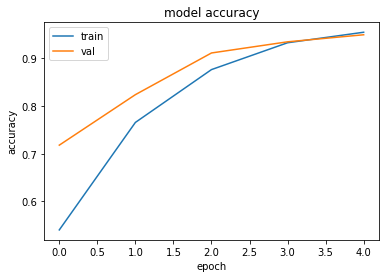

In [184]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

In [185]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

902/902 [==============================] - 1s 1ms/step
Accuracy: 97.339246


In [190]:
pred_prob = model.predict(X_test, verbose = 0)

In [194]:
pred_prob[0:10]

array([[2.52549816e-03, 1.97771471e-02, 4.20285435e-03, 2.29366258e-01,
        2.73194397e-04, 7.83464219e-03, 4.06733714e-03, 7.31953144e-01],
       [4.19865974e-05, 3.15521720e-06, 9.99398589e-01, 6.12651711e-05,
        1.04134589e-04, 5.14380481e-05, 6.32121919e-06, 3.33180156e-04],
       [2.80530122e-03, 2.39799712e-02, 5.91440052e-02, 8.29370081e-01,
        3.00758006e-03, 1.02448941e-03, 5.37300075e-04, 8.01312476e-02],
       [1.18540844e-03, 3.48703610e-03, 9.90204573e-01, 3.96540994e-03,
        7.21472607e-05, 9.41601611e-05, 2.33418075e-04, 7.57990929e-04],
       [7.03898404e-05, 1.86849562e-07, 1.25638589e-05, 2.60348570e-05,
        9.99884486e-01, 5.84719373e-07, 4.10284571e-08, 5.57346129e-06],
       [1.03597595e-04, 3.19877131e-07, 1.54391837e-05, 3.25210203e-05,
        9.99839783e-01, 9.21996218e-07, 8.09205716e-08, 7.30724696e-06],
       [4.85017445e-05, 1.54566800e-03, 4.77197720e-03, 9.11098897e-01,
        2.29444494e-03, 3.54102300e-03, 3.74167430e-05, 7.